# Inferential Analysis on Changes in Snow Depth Due to Elevation

## Introduction

During the winter season, many people like to go hit the slopes to have some fun, and even more so in BC as the province is home to many world-renowned skiing destinations. When choosing a location, one of the main factors perceived by many that contribute to a greater skiing experience is the elevation of the mountain, as it’s believed that a higher elevation leads to an increase in snow depth which helps improve one’s skiing experience. This relationship between elevation and snow depth is a popular claim by the public, with one study suggesting a positive correlation between elevation and snow depth and another suggesting a similar proposition up to an elevation of 3300 meters (Grünewald et al., 2014; Kirchner et al., 2014). As skiing hobbyists ourselves, we wanted to set out and investigate whether this claim is statistically significant. We decided to focus on locations within BC for relevancy, and settled on comparing the snow depths captured by automated snow weather stations placed in two locations with a distinct difference in elevation: Callaghan, an area just west of Whistler with an elevation of 1017 meters, and Silver Star Mountain, home to the famous Silver Star Ski Resort elevated at 1839 meters. As such, our question will be: does the higher elevation of Silver Star Mountain have a greater snow depth than the lower elevation of Callaghan?

Our chosen location and scale parameter will be the mean and standard deviation, respectively. Finding the means of the samples allows us to carry out a one-tailed two-sample t-test which would be relevant for answering the question, while finding the standard deviations will allow us to observe the variability of the observations in each sample.

We’ll be using two datasets from the BC government containing samples of snow depth in centimeters, captured by snow weather stations located in Callaghan and Silver Star Mountain as previously stated. The datasets will be filtered down to contain observations only in the month of January 2019 for reduced variability in measurements caused by seasonal changes (Ye & Ellison, 2003).

## Preliminary Results

Loading necessary libraries:

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(gridExtra)
library(lubridate)
# Install the package
install.packages("infer")
# Load the package
library(infer)

#setting seed to be reproducable
set.seed(276)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reading the csv data files from the data folder. Each corresponding csv file from each location is loaded into a different variable.

In [2]:
snow_depth_callaghan <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/Callaghan/SD.csv', col.names = c("Time", "NULL", "SnowDepth"))
snow_depth_silverstar <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/SilverStar/SD.csv', col.names = c("Time", "NULL", "SnowDepth"))
air_temp_callaghan <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/Callaghan/AT.csv', col.names = c("Time", "NULL", "AirTempCelcius"))
air_temp_silverstar <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/SilverStar/AT.csv', col.names = c("Time", "NULL", "AirTempCelcius"))

head(air_temp_silverstar)
head(snow_depth_silverstar)

,Time,NULL.,AirTempCelcius
,<chr>,<chr>,<chr>
1,"GRADEDESCRIPTIONS-3=GAP, -2=UNUSABLE, -1=UNSPECIFIED, 0=UNDEF, 11=POOR, 21=ESTIMATED, 25=BEST PRACTICE, 31=GOOD, 41=VERYGOOD, 51=EXCELLENT, APPROVALDESCRIPTIONS 800=WORKING, 900=IN REVIEW, 1200=APPROVED",,
2,Timestamp (UTC),Event Timestamp (UTC),Value (°C)
3,2018-09-10 18:00:00,,3
4,2018-09-10 19:00:00,,3.8
5,2018-09-10 20:00:00,,5.7
6,2018-09-10 21:00:00,,6.3


,Time,NULL.,SnowDepth
,<chr>,<chr>,<chr>
1,"GRADEDESCRIPTIONS-3=GAP, -2=UNUSABLE, -1=UNSPECIFIED, 0=UNDEF, 11=POOR, 21=ESTIMATED, 25=BEST PRACTICE, 31=GOOD, 41=VERYGOOD, 51=EXCELLENT, APPROVALDESCRIPTIONS 800=WORKING, 900=IN REVIEW, 1200=APPROVED",,
2,Timestamp (UTC),Event Timestamp (UTC),Value (cm)
3,2015-08-13 22:00:00,,0
4,2015-08-13 23:00:00,,5
5,2015-08-14 00:00:00,,-1
6,2015-08-14 01:00:00,,-4


As you can see above, we must from tidy and wrangle the data. 

In [3]:
# For Each DataSet we filter away the Null/NA values. Then we convert the charachter dates to R's built in date object type.
# Next for the snowdepth we filter away the negative snow depths (impossible/instrument error)
snow_depth_silverstar <- snow_depth_silverstar %>%
    filter(!is.na(SnowDepth)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          SnowDepth = as.numeric(SnowDepth),
          Location = "SilverStar") %>%
    filter(SnowDepth >= 0, !is.na(SnowDepth)) |>
    select(Time, SnowDepth, Location)

snow_depth_callaghan <- snow_depth_callaghan %>%
    filter(!is.na(SnowDepth)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          SnowDepth = as.numeric(SnowDepth),
          Location = "Callaghan") %>%
    filter(SnowDepth >= 0, !is.na(SnowDepth)) |>
    select(Time, SnowDepth, Location)

air_temp_callaghan <- air_temp_callaghan %>%
    filter(!is.na(AirTempCelcius)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          AirTempCelcius = as.numeric(AirTempCelcius),
          Location = "Callaghan") %>%
    filter(!is.na(AirTempCelcius)) |>
    select(Time, AirTempCelcius, Location)

air_temp_silverstar <- air_temp_silverstar %>%
    filter(!is.na(AirTempCelcius)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          AirTempCelcius = as.numeric(AirTempCelcius),
          Location = "SilverStar") %>%
    filter(!is.na(AirTempCelcius)) |>
    select(Time, AirTempCelcius, Location)



head(snow_depth_silverstar)
head(air_temp_callaghan)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


,Time,SnowDepth,Location
,<dttm>,<dbl>,<chr>
1,2015-08-13 22:00:00,0,SilverStar
2,2015-08-13 23:00:00,5,SilverStar
3,2015-08-14 04:00:00,2,SilverStar
4,2015-08-14 05:00:00,3,SilverStar
5,2015-08-14 06:00:00,2,SilverStar
6,2015-08-14 07:00:00,2,SilverStar


,Time,AirTempCelcius,Location
,<dttm>,<dbl>,<chr>
1,2018-10-31 18:00:00,3.2,Callaghan
2,2018-10-31 19:00:00,3.2,Callaghan
3,2018-10-31 20:00:00,3.5,Callaghan
4,2018-10-31 21:00:00,3.9,Callaghan
5,2018-10-31 22:00:00,4.1,Callaghan
6,2018-10-31 23:00:00,4.3,Callaghan


Next lets join all these data sets together. 

In [4]:
#Adding All the SnowDepth Data together
snow_data <- rbind(snow_depth_silverstar,snow_depth_callaghan)
#head(snow_data)
#Adding All the AirTemp Data together
temp_data <- rbind(air_temp_silverstar,air_temp_callaghan)
#head(temp_data)

#Adding all the telementary data together:
telementary <- merge(snow_data, temp_data)
head(telementary)



,Time,Location,SnowDepth,AirTempCelcius
,<dttm>,<chr>,<dbl>,<dbl>
1,2018-09-11 09:00:00,SilverStar,3,2.1
2,2018-09-12 14:00:00,SilverStar,0,1.8
3,2018-09-12 18:00:00,SilverStar,3,4.0
4,2018-09-13 15:00:00,SilverStar,1,1.1
5,2018-09-17 01:00:00,SilverStar,0,0.4
6,2018-09-18 17:00:00,SilverStar,3,2.2


As stated in our introduction, the seasons play a desicive role in snow depth and air temperature. Therefore we will only look at data from the month of January, which is conviently in the dead of the Canadian winter.

In [5]:
jan_data <- telementary |>
    filter(as.numeric(strftime(telementary$Time, "%m")) == 1,
          as.numeric(strftime(telementary$Time, "%Y")) == 2019,) 

#Adding another column to easily graph the dates on the x-axis
jan_data <- jan_data |>
    mutate(Date = as.numeric(strftime(jan_data$Time, "%d")))

## Lets graph the samples of snow depth at Silver Star that we have in 2019.

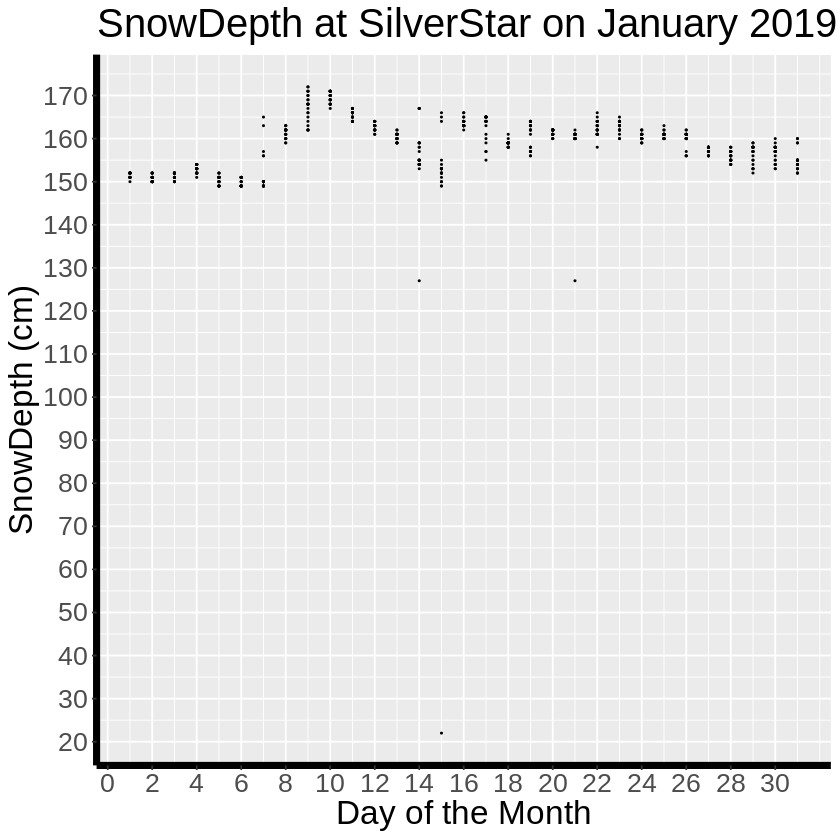

In [6]:
silverstar2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    filter(Location == "SilverStar") |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth), size = 0.2) +
    ggtitle("SnowDepth at SilverStar on January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,200,10))
silverstar2019_plot

## Lets graph the samples of snow depth at Callaghan that we have in 2019.

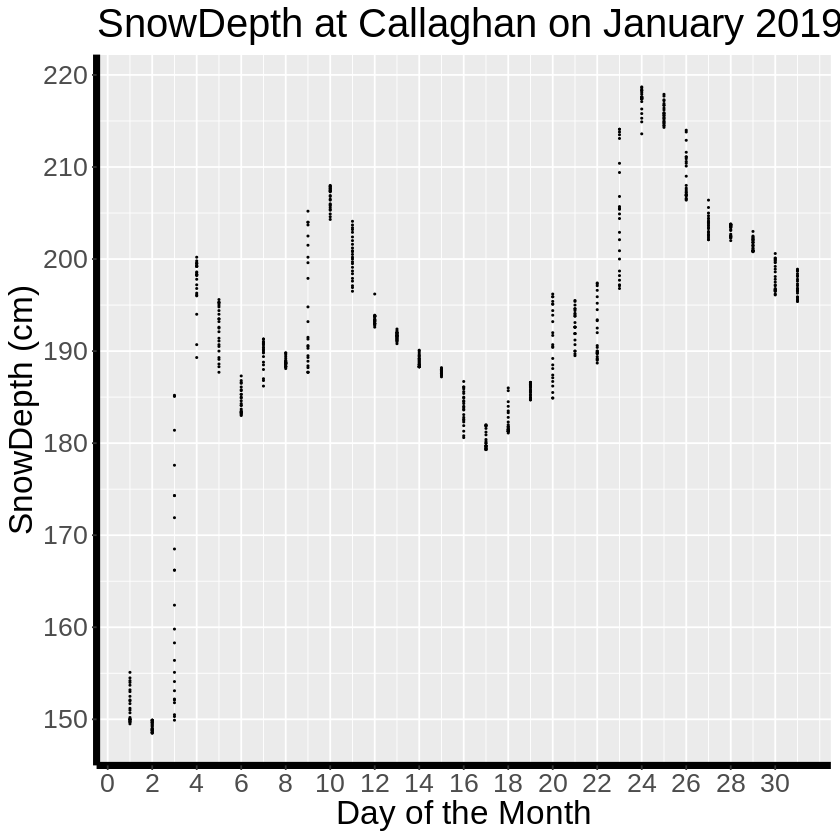

In [7]:
callaghan2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    filter(Location == "Callaghan") |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth), size = 0.2) +
    ggtitle("SnowDepth at Callaghan on January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,300,10))
callaghan2019_plot

## Let's see all the data side by side.

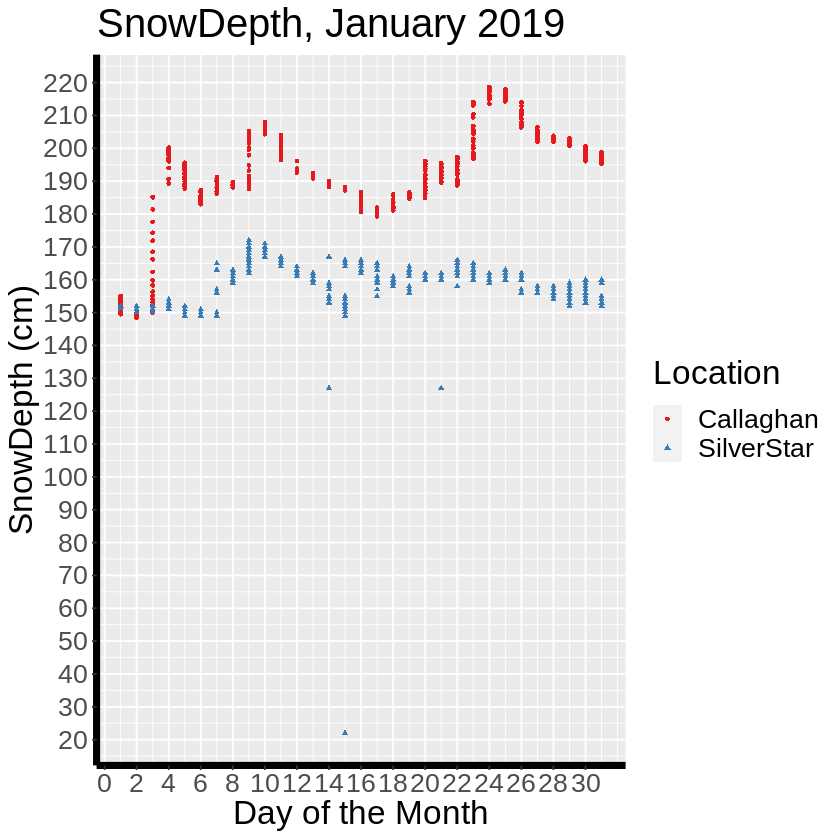

In [8]:
jan2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth, color = Location, shape = Location), size = 1) +
    ggtitle("SnowDepth, January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,300,10)) +
    scale_color_brewer(palette = "Set1")
jan2019_plot

 Wow! Not what we expected. Seems like elevation is a sufficient predictor for snow depth. Can't say for sure until we do the hypothesis test. (stay tuned).
#### Let's try and estimate the mean snowdepth (cm) for each location for January 2019.

In [9]:
jan_2019_summary <- jan_data |>
    group_by(Location) |>
    summarize(MeanSnowDepth = mean(SnowDepth))
jan_2019_summary

Location,MeanSnowDepth
<chr>,<dbl>
Callaghan,191.5876
SilverStar,158.2051


## Lets add this mean to the plot.

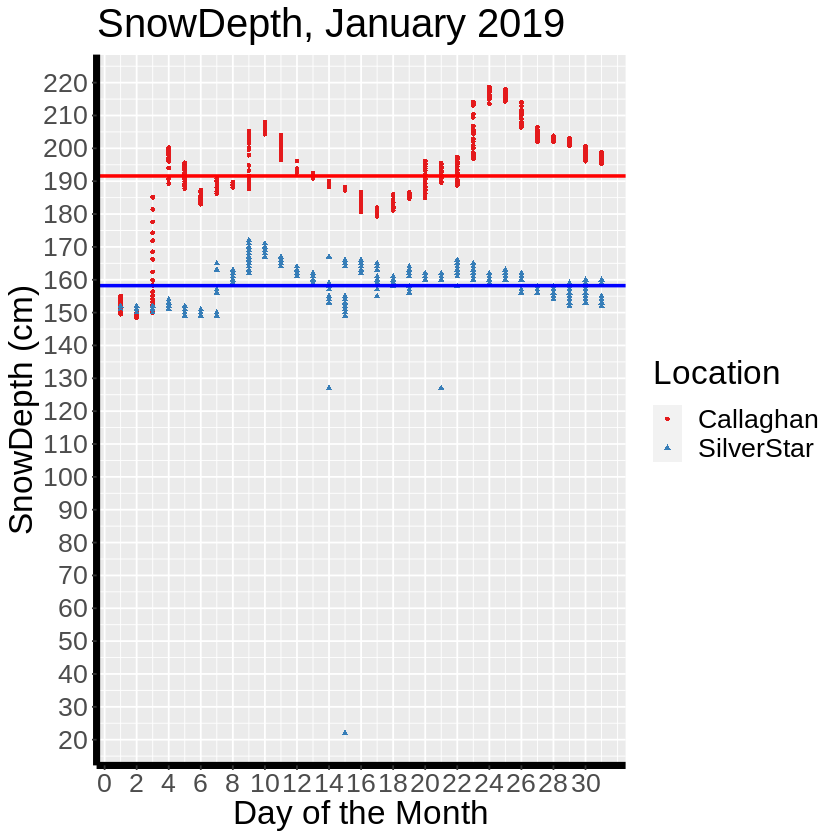

In [17]:
jan_2019_plot_summary <- jan2019_plot +
    geom_hline(yintercept = jan_2019_summary$MeanSnowDepth[1],color = "red", size= 1) +
    geom_hline(yintercept = jan_2019_summary$MeanSnowDepth[2],color = "blue", size= 1)

jan_2019_plot_summary

## Methods: Plan

From our preliminary results, we see that the mean snow depth for Callaghan is actually greater than Silver Star, so based on that we can expect to find that a higher elevation does not lead to greater snow depth. We’ll state the null hypothesis to be that there’s no difference between the mean snow depths of Silver Star and Callaghan and our alternate hypothesis to be that the difference between Silver Star and Callaghan snow depths is greater than zero (ie. mean snow depth of Silver Star is greater than mean snow depth of Callaghan). 

We will also calculate the confidence intervals through bootstrapping and asymptotic methods (normal distribution, CLT, t-distribution) to evaluate the accuracy of our estimates. If our expected findings are correct, then we can also expect to not reject the null hypothesis. Based on our expected findings, if higher elevation does not lead to greater snow depth, then more questions could be raised on why this is, such as the geography/location of the mountains playing a larger role in snow depth. Our expected conclusions could also help future companies/wealthy investors evaluate new locations for ski resorts, knowing whether elevation is or isn't a big factor in ensuring sufficient snow depth for a good skiing experience.


## Bootstrapping

In [ ]:
# bootstrap for snow depth for SilverStart
location_silverstart <- jan_data %>% 
     filter(Location == "SilverStar")

dist_mean_depth_silverstart <- 
     location_silverstart %>% 
     specify(response = Location) %>%
     hypothesize(null = "point", mu=158.2051) %>%
     generate(reps = 1000, type = "bootstrap") %>%
     calculate(stat = "mean")

head(dist_mean_depth_silverstart)

# bootstrap for snow depth for Callaghan
# dist_mean_depth_callaghan <- 
#      jan_data %>% 
#      filter(Location == "Callaghan") %>%
#      rep_sample_n(reps = 100, size = 1000, replace = TRUE) %>% 
#      group_by(replicate) %>% 
#      summarize(mean_callaghan = mean(SnowDepth)) %>% 
#      select(mean_callaghan)

# head(dist_mean_depth_callaghan)

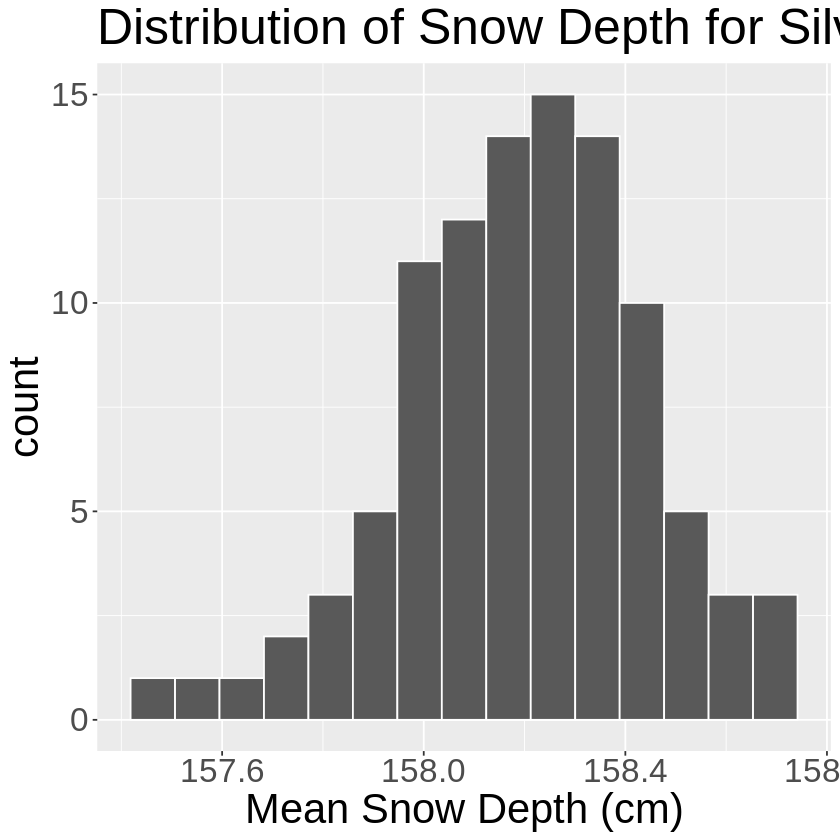

In [13]:
# Distribtuion of snow depth of SilverStart

boot_snow_plot_silverstart <-
     dist_mean_depth_silverstart %>% 
     ggplot() +
     geom_histogram(aes(mean_silverstart), bins = 15, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Distribution of Snow Depth for SilverStart") 

boot_snow_plot_silverstart

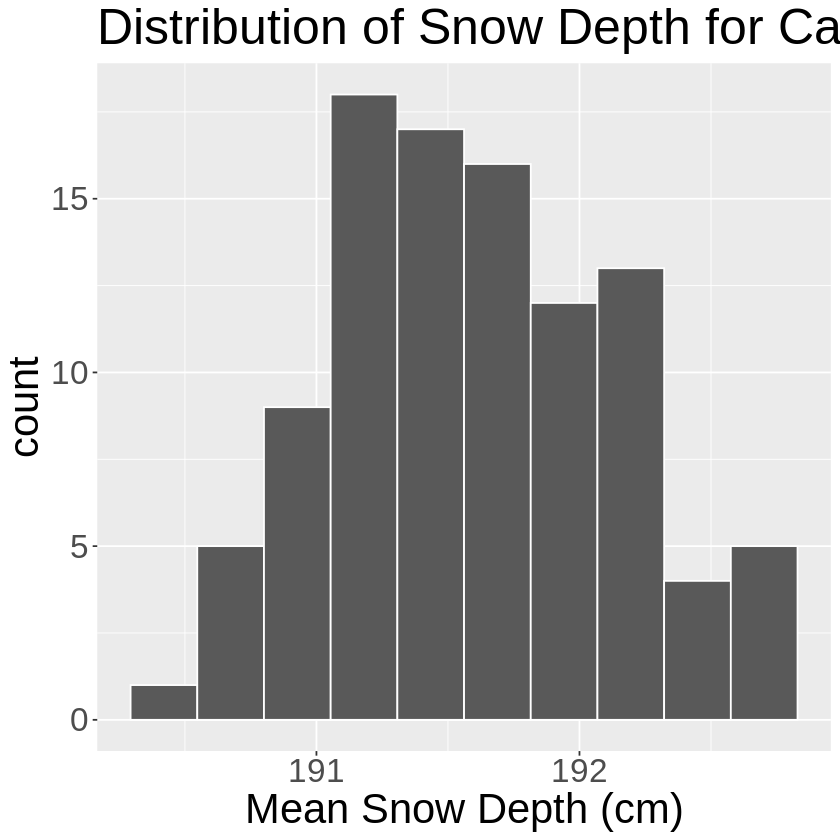

In [14]:
# Distribtuion of snow depth of Callaghan

boot_snow_plot_callaghan <-
     dist_mean_depth_callaghan %>% 
     ggplot() +
     geom_histogram(aes(mean_callaghan), bins = 10, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Distribution of Snow Depth for Callaghan") 

boot_snow_plot_callaghan

## Confidence Interval for Bootstrapping

In [15]:
# ci for SilverStart

ci_silverstart <- 
    dist_mean_depth_silverstart %>% 
    summarize(ci_lower = quantile(mean_silverstart, 0.05),
              ci_upper = quantile(mean_silverstart, 0.95))
head(ci_silverstart)

# ci for Callaghan

ci_callaghan <- dist_mean_depth_callaghan %>%
    summarize(ci_lower = quantile(mean_callaghan, 0.05),
              ci_upper = quantile(mean_callaghan, 0.95))
head(ci_callaghan)   

ci_lower,ci_upper
<dbl>,<dbl>
157.7946,158.576


ci_lower,ci_upper
<dbl>,<dbl>
190.7619,192.5615


In [ ]:
head(jan_data)

## Sample Distributions

In [ ]:
# PLotting Callaghan sample distribution for the month of january
call_sample_dist_plot <-
     jan_data %>% 
    filter(Location == "Callaghan") %>% 
     ggplot() +
     geom_histogram(aes(x=SnowDepth), bins = 15, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=19)) + 
     ggtitle("Callaghan Snow Depth Sample Distribution") 
call_sample_dist_plot

silv_sample_dist_plot <-
     jan_data %>% 
    filter(Location == "SilverStar") %>% 
     ggplot() +
     geom_histogram(aes(x=SnowDepth), color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=19)) + 
     ggtitle("SilverStar Snow Depth Sample Distribution") 
silv_sample_dist_plot

## References

Grünewald, T., Bühler, Y., & Lehning, M. (2014). Elevation dependency of mountain snow depth. The Cryosphere, 8(6), 2381–2394. https://doi.org/10.5194/tc-8-2381-2014

Kirchner, P. B., Bales, R. C., Molotch, N. P., Flanagan, J., & Guo, Q. (2014). LiDAR measurement of seasonal snow accumulation along an elevation gradient in the southern Sierra Nevada, California. Hydrology and Earth System Sciences, 18(10), 4261–4275. https://doi.org/10.5194/hess-18-4261-2014

Ye, H., & Ellison, M. (2003). Changes in transitional snowfall season length in northern Eurasia: TRANSITIONAL SNOWFALL SEASON. Geophysical Research Letters, 30(5), n/a-n/a. https://doi.org/10.1029/2003GL016873


### Data Sources

Government of British Columbia. (2022) Callagan Telementary. https://aqrt.nrs.gov.bc.ca/Data/Location/Summary/Location/3A20P/Interval/Latest

Government of British Columbia. (2022) Silver Star Mountain  Telementary. https://aqrt.nrs.gov.bc.ca/Data/Location/Summary/Location/2F10P/Interval/Latest